In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
import re 
import nltk
import nltk.corpus 
from nltk.corpus import stopwords
import string
import json
from time import time 
import pickle 
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
#Read text captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
        return captions

In [3]:
captions = readTextFile("/Users/apple/Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [4]:
#dictionary to map each image with the list of captions it has

descriptions = {}

for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)
  

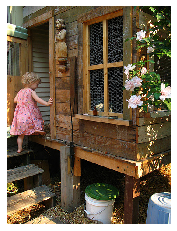

In [5]:
img_path = "/Users/apple/Desktop/flickr8k/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
#Data Cleaning
 
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [7]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [8]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
with open("descriptions_1.text","w") as f:
    f.write(str(descriptions))

In [10]:
#VOCABULARY
descriptions = None
with open("descriptions_1.text","r") as f:
    descriptions = f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions  = json.loads(json_acceptable_string)

In [11]:
#unique words
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [12]:
print("vocab size:%d"%len(vocab))

vocab size:8424


In [13]:
#total no. of words
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]


In [14]:
print("total words:%d"%len(total_words))

total words:373837


In [15]:
#Filter words from the Vocab on the basis of certain threshold frequency

import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)

In [16]:
sorted_frq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

In [17]:
threshold = 10
sorted_frq_cnt = [x for x in sorted_frq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_frq_cnt]

In [18]:
train_file_data = readTextFile("/Users/apple/Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/Users/apple/Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [19]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [20]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [21]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [22]:
model = ResNet50(weights = "imagenet" , input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [23]:
model_new = Model(model.input,model.layers[-2].output)

In [24]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    #Normalisation
    img = preprocess_input(img)
    return img
    

In [25]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [28]:
start = time()
encoding_train = {}

for ix,img_id in enumerate(train):
    img_path1 = img_path+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path1)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d"%ix)
        
end_t = time()
print("Total Time Taken: ",end_t-start)
        

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900
Encoding in Progress Time step 1000
Encoding in Progress Time step 1100
Encoding in Progress Time step 1200
Encoding in Progress Time step 1300
Encoding in Progress Time step 1400
Encoding in Progress Time step 1500
Encoding in Progress Time step 1600
Encoding in Progress Time step 1700
Encoding in Progress Time step 1800
Encoding in Progress Time step 1900
Encoding in Progress Time step 2000
Encoding in Progress Time step 2100
Encoding in Progress Time step 2200
Encoding in Progress Time step 2300
Encoding in Progress Time step 2400
Encoding in Progress Time step 2500
Encoding in Progress Time step 2600
Encoding in Progress Time step 2700
Enco

In [30]:
with open('./encoded_train_features.pickle','wb') as f:
    pickle.dump(encoding_train,f)

In [31]:
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path1 = img_path+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path1)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d"%ix)
        
end_t = time()
print("Total Time Taken: ",end_t-start)

Test Encoding in Progress Time step 0
Test Encoding in Progress Time step 100
Test Encoding in Progress Time step 200
Test Encoding in Progress Time step 300
Test Encoding in Progress Time step 400
Test Encoding in Progress Time step 500
Test Encoding in Progress Time step 600
Test Encoding in Progress Time step 700
Test Encoding in Progress Time step 800
Test Encoding in Progress Time step 900
Total Time Taken:  231.00335907936096


In [32]:
with open('./encoded_test_features.pickle','wb') as f:
    pickle.dump(encoding_test,f)

In [33]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [34]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(idx_to_word) + 1

In [35]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

In [36]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True :
        for key,desc_list in train_descriptions.items():
            n+=1
            
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    
                    xi = pad_sequences([xi],maxlen = max_len,value=0,padding = 'post')[0]
                    yi = to_categorical([yi],num_classes = vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y = [],[],[]
                    n=0

In [37]:
f = open("/Users/apple/Desktop/glove-global-vectors-for-word-representation/glove.6B.50d.txt",encoding='utf8')

In [38]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding
    

In [39]:
embedding_index['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [40]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix


In [41]:
embedding_matrix = get_embedding_matrix() 
embedding_matrix.shape

(1848, 50)

In [42]:
input_img_features = Input(shape=(2048,))
img_layer_1 = Dropout(0.3)(input_img_features)
img_layer_2 = Dense(256,activation='relu')(img_layer_1)

In [43]:
input_cap_features = Input(shape = (max_len,))
embeddings = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_cap_features)
cap_features_1 = Dropout(0.3)(embeddings)
cap_features_2 = LSTM(256)(cap_features_1)

In [44]:
final_model_input = add([img_layer_2,cap_features_2])
final_model_1 = Dense(256,activation='relu')(final_model_input)
final_model_input_2 = Dense(vocab_size,activation='softmax')(final_model_1)

model = Model(inputs = [input_img_features,input_cap_features],outputs = final_model_input_2)

In [45]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [47]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam')

In [62]:
epochs = 20
batch_size = 3 
steps = len(train_descriptions)//batch_size

In [63]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('/Users/apple/Desktop/glove-global-vectors-for-word-representation/model_weights' + str(i) + '.h5')

In [64]:
model.load_weights("/Users/apple/Desktop/glove-global-vectors-for-word-representation/model_weights19.h5")

In [65]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence  = pad_sequences([sequence],maxlen=max_len,padding = 'post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text +=' ' + word
        
        if word=='endseq':
            break
            
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

jockeys race in race


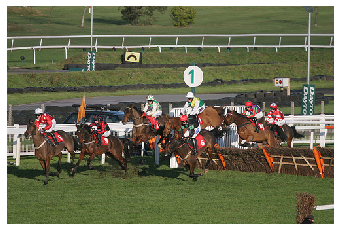

beagle jumps into the pool


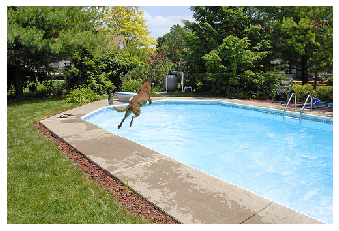

man in red coat is walking in front of crowd of people


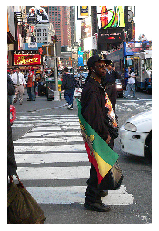

group of people are riding bicycles on track


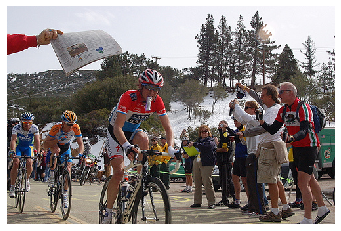

two people are walking on snowy mountain


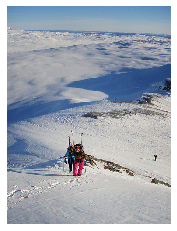

group of people are standing in front of large building


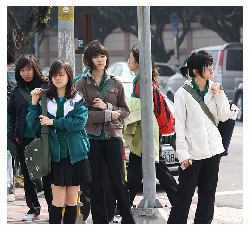

little boy in pajamas is sitting on bench


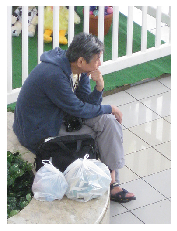

man is doing trick on his bike


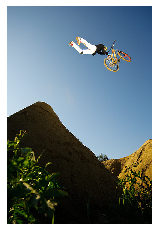

brown dog is running through the woods


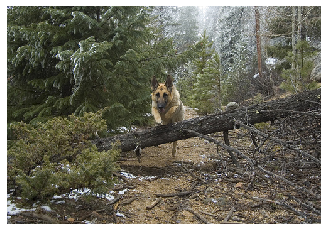

climber scaling sheer rock face


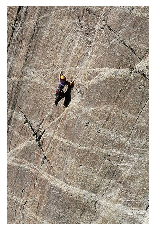

dog running in the sand


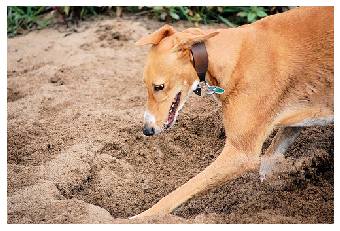

boy in blue shirt and blue shorts is playing baseball


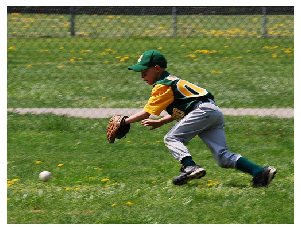

little boy in denim jacket is sitting on the edge of plastic slide


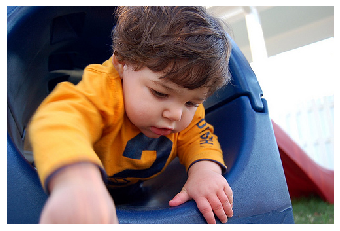

man in harness is climbing up rocky face


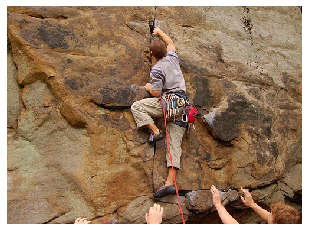

little girl in yellow dress is standing on the grass crying


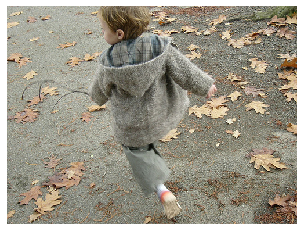

boy in red shirt and jeans is pushing on the sidewalk


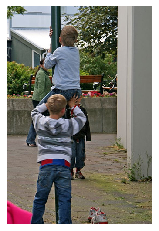

young girl in blue swim trunks is paddling in the water


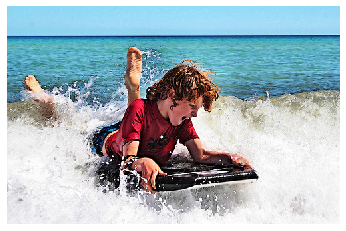

boy in red shirt and blue jeans is pushing another boy in denim


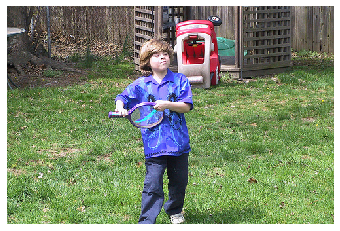

young girl in swimsuit is running through the water


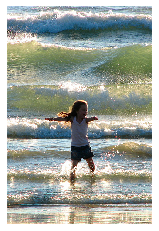

two dogs are running through the sand


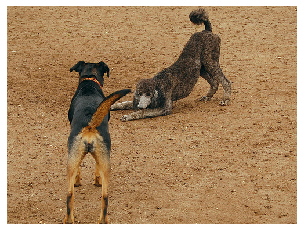

little girl in pink shirt is pushing on shovel swing


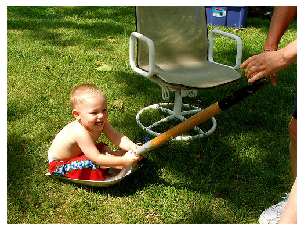

boy in blue shirt and jeans skateboards on skateboard


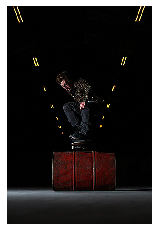

dog running through the grass


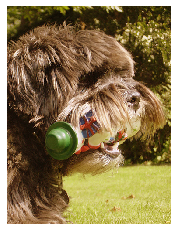

young girl in bikini is running on the beach


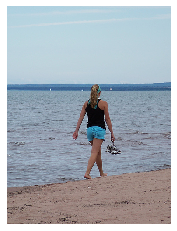

two men in suits are standing beside street


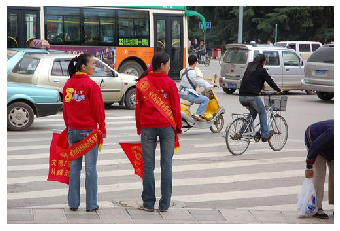

In [66]:
for i in range(25):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_train.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_train[img_name].reshape((1,2048))
    
    i = plt.imread(img_path+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    
    plt.imshow(i)
    plt.axis("off")
    plt.show()